We generate an active occupancy profile, $A$, for a dwelling with a 9-5 weekday schedule. Dwelling is 'actively occupied' between 6am and 9am, and 6pm and midnight. Outside of these times, we assume the occupant is either absent (e.g. at work) or present but not active (e.g. asleep).

$A = \{a_1,...,a_T\}$ where $a_t \in \{0, 1\}$


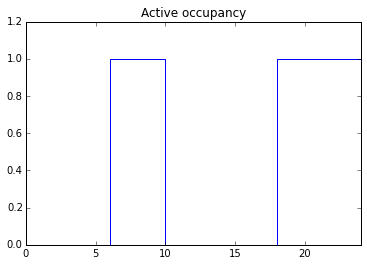

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.art3d as art3d
#import seaborn
import random 


t_labels = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
occupancy = [0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1.001] #value 1.001 there to fix axes
plt.figure()
plt.step(t_labels, occupancy)
plt.title("Active occupancy")
plt.xlim(0,24)
plt.show()

T = len(t_labels)


We produce a number of sample responses for reduction requests issued during the active time periods ($t=3$, $t=4$, $t=9$, $t=10$ and $t=11$)

We assume that all loads are shifted to one of those three active time periods.

We plot the responses. Jitter has been added to the points to remove the overlap.

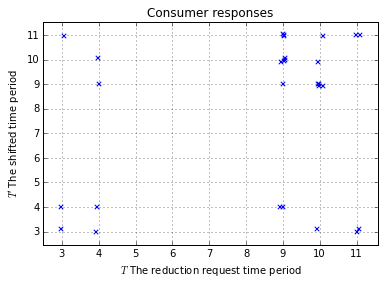

In [20]:
responses = []

num_r = [0, 0, 0, 3, 4, 0, 0, 0, 0, 10, 7, 4] #number of requests made during each time period
for t in range(T):
    r = []
    for i in range(num_r[t]):
        r.append(random.choice([3, 4, 9, 10, 11]))
    responses.append(r)
    
responses

def jitter(epsilon):
    return random.random() % (2*epsilon) - epsilon

x = []
y = []
epsilon = 0.10
for t in range(T):
    for response in responses[t]:
        x.append(t + jitter(epsilon))
        y.append(response + jitter(epsilon))

fig = plt.figure()
ax = fig.gca()
ax.set_xticks(range(T))
ax.set_yticks(range(T))
        
plt.scatter(x, y, marker='x')




plt.title("Consumer responses")
plt.xlabel("$T$ The reduction request time period")
plt.ylabel("$T'$ The shifted time period")
plt.grid()
plt.show()
    

In [27]:
gmm_data = np.vstack((x, y))

We count the occurrences. 

In [3]:
counts = []
for r in responses:
    c = [0]*T
    for i in r:
        c[i] = c[i] + 1
    counts.append(c)


And normalise the counts to produce probabilities

In [4]:
probs = []
for c in counts:
    s = sum(c)
    if (s > 0):
        p = [float(c[i])/s for i in range(len(c))]
        probs.append(p)
    else:
        probs.append([0]*T)



We plot the probability matrix, $P$, a $T$ x $T$ matrix, where $p_{t, t'} = P(t' | t)$, i.e. the probability of the load being shifted to time period $t'$, given that a reduction request for time $t$ was issued.

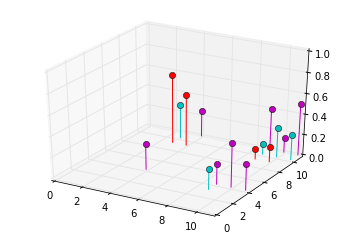

In [5]:
#plot probabilities


colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')

x = y = range(0, T)
z = probs
for xi in x:
    for yi in y:    
        line=art3d.Line3D([xi,xi],[yi,yi],[0,probs[xi][yi]], marker='o', markevery=(1, 1), color=colours[yi%len(colours)])
        if probs[xi][yi] > 0: #only show non zero probabilities.
            ax.add_line(line)
ax.set_xlim3d(0, T-1)
ax.set_ylim3d(0, T-1)
ax.set_zlim3d(0, 1)    
plt.show()

In [41]:
import numpy as np
from sklearn import mixture

g = mixture.GMM(n_components=2)

print(np.shape(gmm_data))
g.fit(np.transpose(gmm_data))

np.round(g.means_, 1)

(2L, 28L)


array([[  8.7,  10. ],
       [  7.1,   3.5]])

IndexError: list index out of range

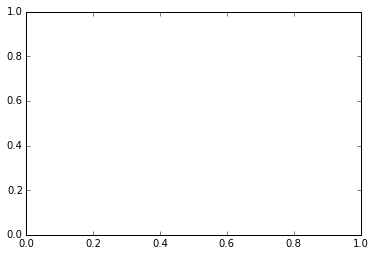

In [42]:
import matplotlib as mpl

def make_ellipses(gmm, ax):
    for n, color in enumerate('rgb'):
        v, w = np.linalg.eigh(gmm._get_covars()[n][:2, :2])
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v *= 9
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        
make_ellipses(g, plt.gca())
